In [26]:
import numpy as np
import pandas as pd
from imblearn.combine import SMOTEENN
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import time


In [27]:
#Load and Preprocess Data
df = pd.read_csv('data_ecommerce_customer_churn.csv')
df.head(10)

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
5,7.0,16.0,4,Mobile Phone,2,Divorced,2,0,11.0,152.81,0
6,1.0,15.0,6,Mobile Phone,5,Divorced,3,0,2.0,149.51,0
7,1.0,11.0,4,Mobile Phone,5,Single,3,0,1.0,154.73,1
8,11.0,12.0,4,Mobile Phone,3,Married,2,0,4.0,137.02,0
9,17.0,7.0,3,Laptop & Accessory,1,Married,5,1,2.0,157.43,0


In [28]:
#Show the total number of missing values in each column
print(df.isnull().sum())

Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64


In [29]:
# Handle missing values
df.fillna(df.select_dtypes(include=[np.number]).mean(), inplace=True)
df.head(10)

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.000000,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.000000,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.000000,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,4.531652,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.000000,322.17,0
5,7.0,16.0,4,Mobile Phone,2,Divorced,2,0,11.000000,152.81,0
6,1.0,15.0,6,Mobile Phone,5,Divorced,3,0,2.000000,149.51,0
7,1.0,11.0,4,Mobile Phone,5,Single,3,0,1.000000,154.73,1
8,11.0,12.0,4,Mobile Phone,3,Married,2,0,4.000000,137.02,0
9,17.0,7.0,3,Laptop & Accessory,1,Married,5,1,2.000000,157.43,0


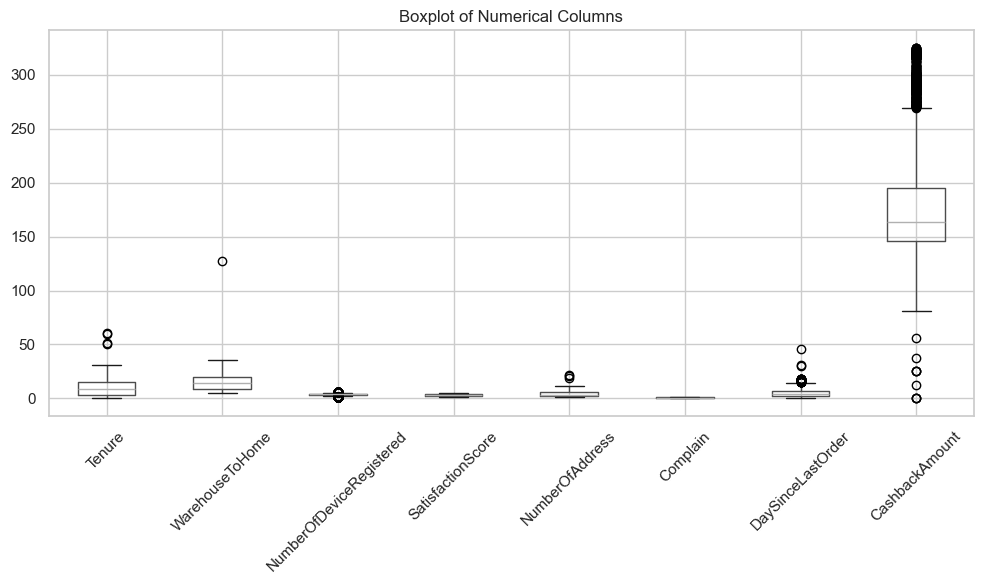

In [30]:
#Boxplot to visualize the distribution of numerical features
num_column = df.select_dtypes(include=['int64', 'float64']).columns
num_column = num_column.drop('Churn')
# Plot boxplot for all numerical columns
df[num_column].boxplot(figsize=(10, 6))
plt.title('Boxplot of Numerical Columns')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()
plt.show()

In [31]:
# Encode categorical features
label_encoder = LabelEncoder()
df['PreferedOrderCat'] = label_encoder.fit_transform(df['PreferedOrderCat'])
df['MaritalStatus'] = label_encoder.fit_transform(df['MaritalStatus'])
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,2,3,2,2,0,7.000000,143.32,0
1,7.0,25.0,4,3,1,1,2,0,7.000000,129.29,0
2,27.0,13.0,3,2,1,1,5,0,7.000000,168.54,0
3,20.0,25.0,4,0,3,0,7,0,4.531652,230.27,0
4,30.0,15.0,4,5,4,2,8,0,8.000000,322.17,0


In [32]:
# Feature scaling
scaler = StandardScaler()
features_to_scale = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore',
                     'NumberOfAddress', 'DaySinceLastOrder', 'CashbackAmount']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,0.593608,1.614590,0.316362,2,-0.063911,2,-0.852035,0,0.692058,-0.684370,0
1,-0.371883,1.130797,0.316362,3,-1.511448,1,-0.852035,0,0.692058,-0.971955,0
2,2.041846,-0.320584,-0.670017,2,-1.511448,1,0.290227,0,0.692058,-0.167415,0
3,1.197041,1.130797,0.316362,0,-0.063911,0,1.051736,0,0.000000,1.097918,0
4,2.403905,-0.078687,0.316362,5,0.659858,2,1.432490,0,0.972430,2.981671,0


In [33]:
# Feature Engineering
df['Tenure_Satisfaction'] = df['Tenure'] * df['SatisfactionScore']
df['RecencyAdjustedSatisfaction'] = df['SatisfactionScore'] / (df['DaySinceLastOrder'] + 1)
df['TenurePerDevice'] = df['Tenure'] / (df['NumberOfDeviceRegistered'] + 1)
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn,Tenure_Satisfaction,RecencyAdjustedSatisfaction,TenurePerDevice
0,0.593608,1.614590,0.316362,2,-0.063911,2,-0.852035,0,0.692058,-0.684370,0,-0.037938,-0.037771,0.450946
1,-0.371883,1.130797,0.316362,3,-1.511448,1,-0.852035,0,0.692058,-0.971955,0,0.562082,-0.893261,-0.282508
2,2.041846,-0.320584,-0.670017,2,-1.511448,1,0.290227,0,0.692058,-0.167415,0,-3.086144,-0.893261,6.187725
3,1.197041,1.130797,0.316362,0,-0.063911,0,1.051736,0,0.000000,1.097918,0,-0.076504,-0.063911,0.909355
4,2.403905,-0.078687,0.316362,5,0.659858,2,1.432490,0,0.972430,2.981671,0,1.586237,0.334541,1.826173


In [34]:
# Features and target
X = df.drop(['Churn'], axis=1)
y = df['Churn']


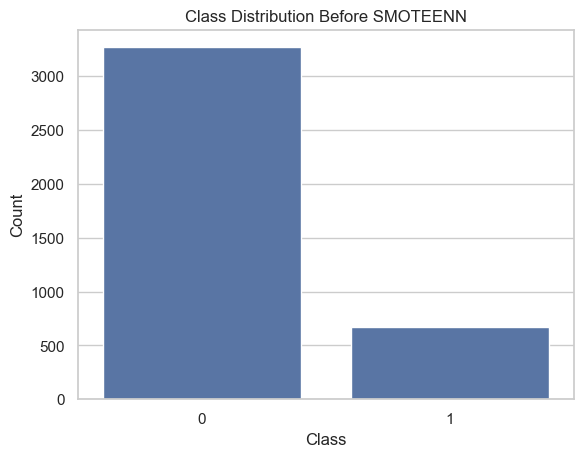

In [35]:
#Class distribution before SMOTEENN
def plot_class_distribution(y, title):
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()
plot_class_distribution(y, "Class Distribution Before SMOTEENN")

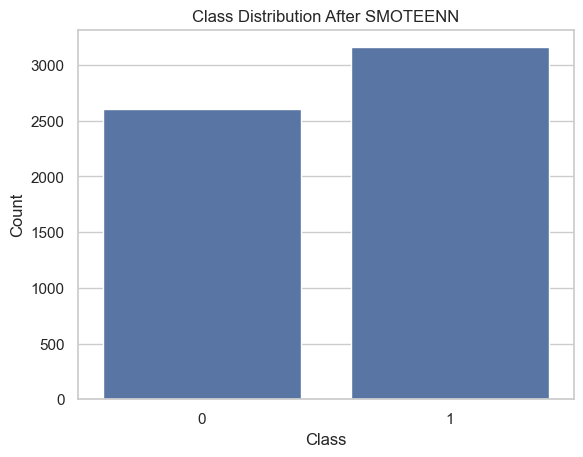

In [36]:
# Handle Class Imbalance and show visualization
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X, y)
plot_class_distribution(y_res, "Class Distribution After SMOTEENN")

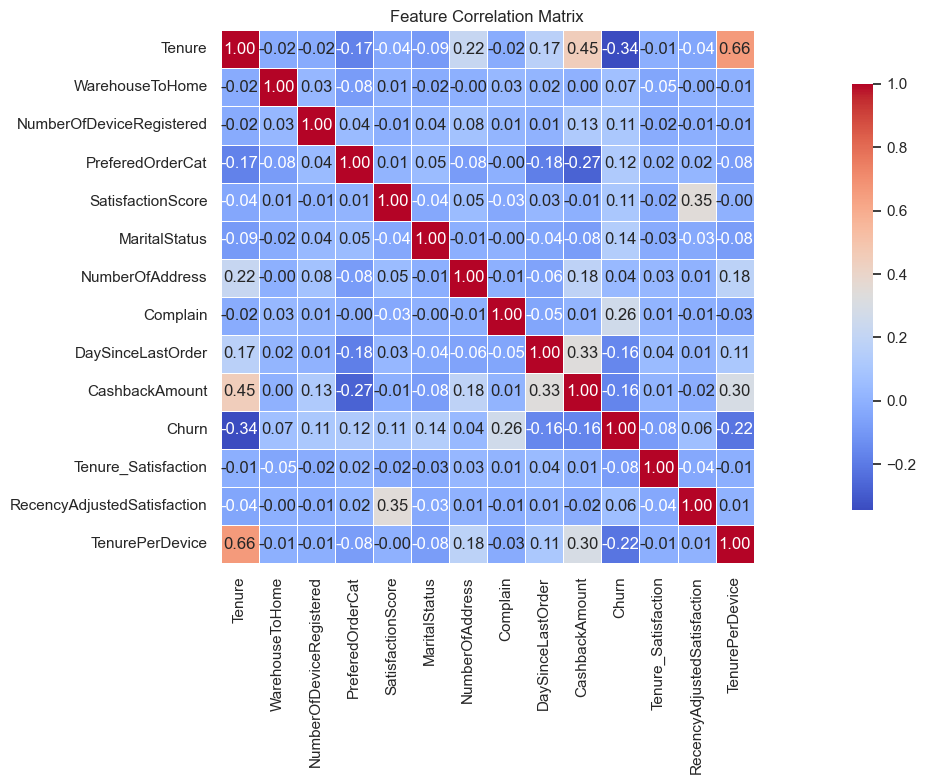

d:\ML Projects\Customer_Churn_Prediction_using_ML\correlation_matrix.png

In [37]:
#Correlation Matrix (Feature Relationships)
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix (only numeric columns)
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True,
            cbar_kws={"shrink": .8}, linewidths=0.5)
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()
from IPython.display import FileLink
FileLink('correlation_matrix.png')

In [38]:
#  Feature Selection
selector = SelectKBest(f_classif, k='all')
X_res_selected = selector.fit_transform(X_res, y_res)
X_selected_columns = X_res.columns[selector.get_support()]

In [39]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res_selected, y_res, test_size=0.2, random_state=42)
np.random.seed(42)

In [40]:
#Initialize Models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'KNN': KNeighborsClassifier() 
}

In [41]:
#  Hyperparameter Tuning (optional)
def tune_model(model, param_grid, X_train, y_train):
    try:
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        return grid_search.best_estimator_, grid_search.best_params_
    except Exception as e:
        print(f"Tuning error: {e}")
        return model, None

In [42]:
# Initialize a dictionary to store model metrics
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}
#Evaluate Models
def evaluate_model(model, X_train, X_test, y_train, y_test,model_name):
    try:
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        y_pred = model.predict(X_test)
        train_accuracy = accuracy_score(y_train, model.predict(X_train)) * 100
        test_accuracy = accuracy_score(y_test, y_pred) * 100
        report = classification_report(y_test, y_pred)
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred) * 100
        precision = precision_score(y_test, y_pred) * 100
        recall = recall_score(y_test, y_pred) * 100
        f1 = f1_score(y_test, y_pred) * 100

        # Store metrics
        metrics['Model'].append(model_name)
        metrics['Accuracy'].append(accuracy)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1 Score'].append(f1)

        
        print(f"Training Accuracy: {train_accuracy:.3f}%")
        print(f"Testing Accuracy: {test_accuracy:.3f}%")
        print(f"Training Time: {training_time:.3f}s")
        print(report)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    except Exception as e:
        print(f"Error in model evaluation: {e}")



--- Evaluating Random Forest ---
Training Accuracy: 100.000%
Testing Accuracy: 98.005%
Training Time: 0.528s
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       530
           1       0.99      0.97      0.98       623

    accuracy                           0.98      1153
   macro avg       0.98      0.98      0.98      1153
weighted avg       0.98      0.98      0.98      1153



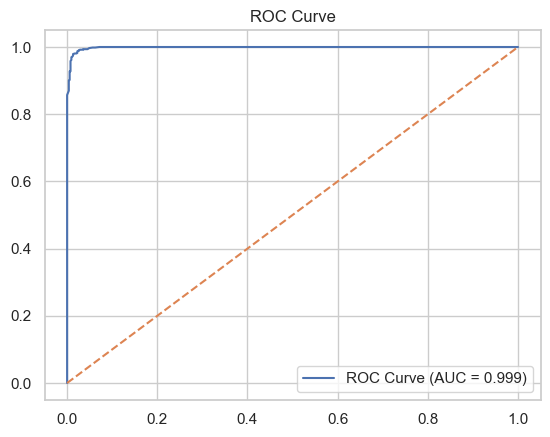

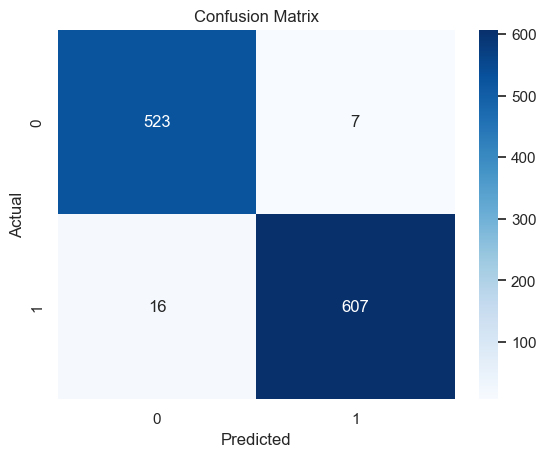


--- Evaluating XGBoost ---
Training Accuracy: 100.000%
Testing Accuracy: 97.832%
Training Time: 0.093s
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       530
           1       0.99      0.97      0.98       623

    accuracy                           0.98      1153
   macro avg       0.98      0.98      0.98      1153
weighted avg       0.98      0.98      0.98      1153



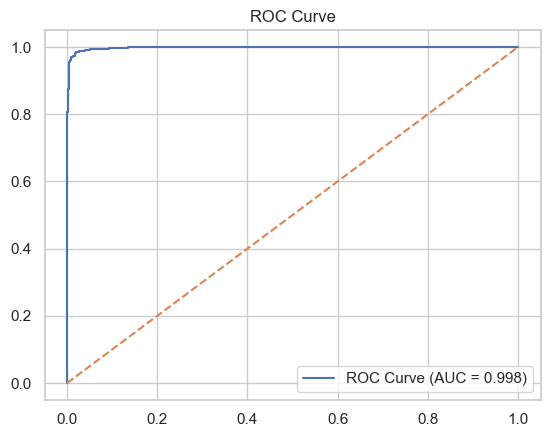

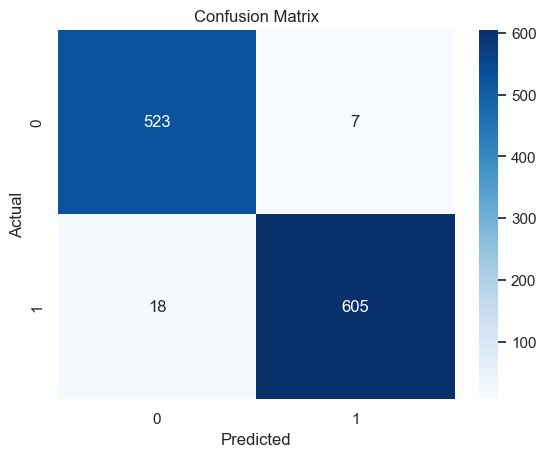


--- Evaluating Logistic Regression ---
Training Accuracy: 79.072%
Testing Accuracy: 79.185%
Training Time: 0.054s
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       530
           1       0.80      0.81      0.81       623

    accuracy                           0.79      1153
   macro avg       0.79      0.79      0.79      1153
weighted avg       0.79      0.79      0.79      1153



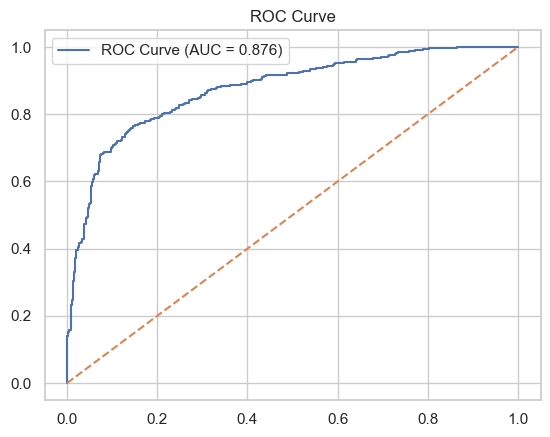

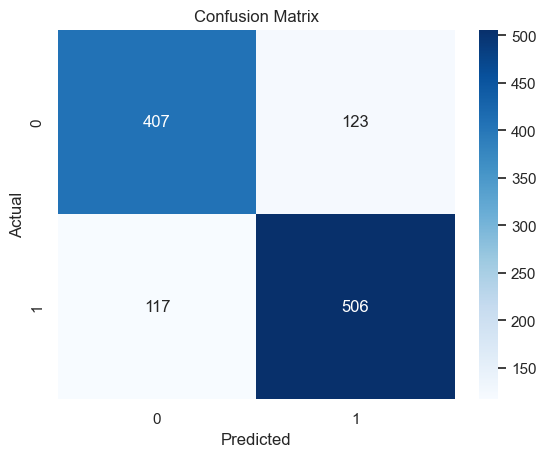


--- Evaluating Gradient Boosting ---
Training Accuracy: 94.513%
Testing Accuracy: 92.975%
Training Time: 0.835s
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       530
           1       0.95      0.92      0.93       623

    accuracy                           0.93      1153
   macro avg       0.93      0.93      0.93      1153
weighted avg       0.93      0.93      0.93      1153



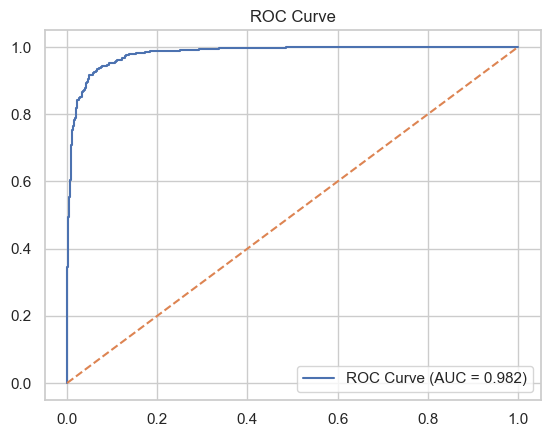

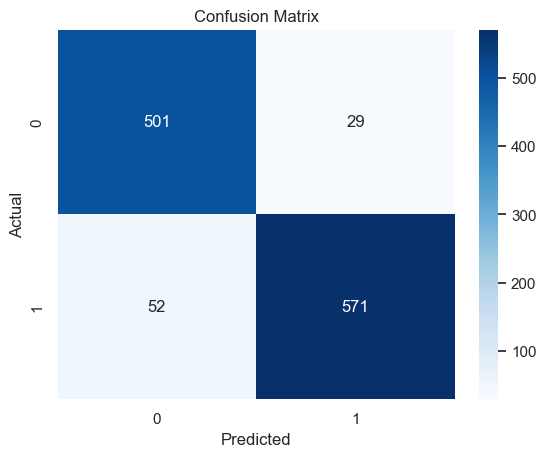


--- Evaluating SVM ---
Training Accuracy: 77.033%
Testing Accuracy: 75.889%
Training Time: 2.700s
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       530
           1       0.76      0.81      0.78       623

    accuracy                           0.76      1153
   macro avg       0.76      0.75      0.76      1153
weighted avg       0.76      0.76      0.76      1153



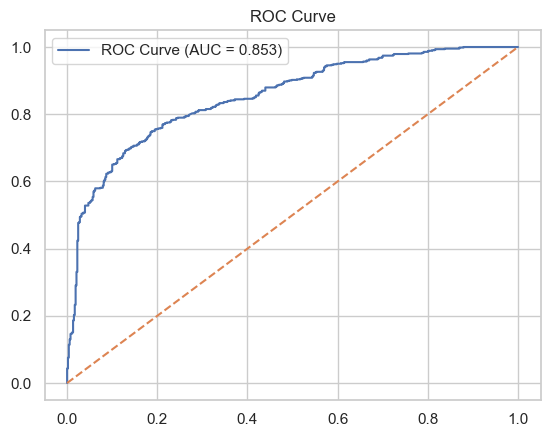

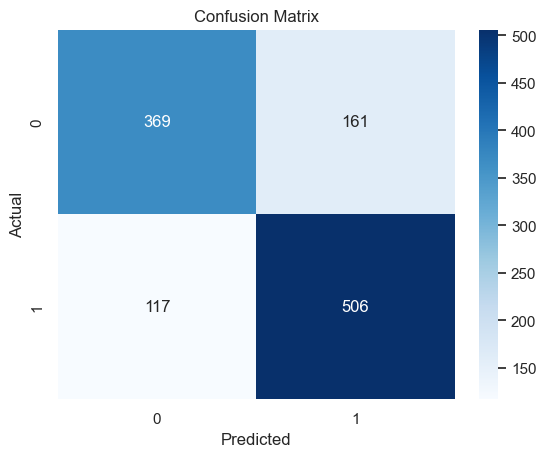


--- Evaluating LightGBM ---
[LightGBM] [Info] Number of positive: 2537, number of negative: 2074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 4611, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550206 -> initscore=0.201503
[LightGBM] [Info] Start training from score 0.201503
Training Accuracy: 99.913%
Testing Accuracy: 98.265%
Training Time: 0.090s
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       530
           1       0.99      0.98      0.98       623

    accuracy                           0.98      1153
   macro avg       0.98      0.98      0.98      1153
weighted avg       0.98      0.98      0.98      1153



d:\ML Projects\Customer_Churn_Prediction_using_ML\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\ML Projects\Customer_Churn_Prediction_using_ML\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\ML Projects\Customer_Churn_Prediction_using_ML\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


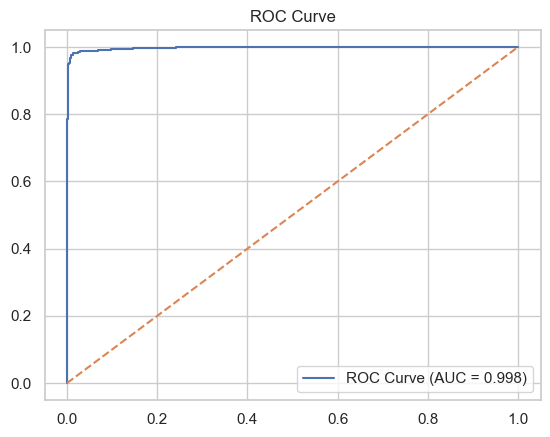

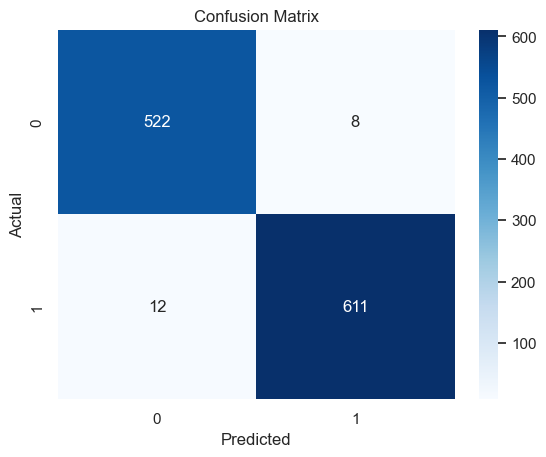


--- Evaluating KNN ---
Training Accuracy: 98.482%
Testing Accuracy: 95.663%
Training Time: 0.008s
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       530
           1       0.94      0.98      0.96       623

    accuracy                           0.96      1153
   macro avg       0.96      0.95      0.96      1153
weighted avg       0.96      0.96      0.96      1153



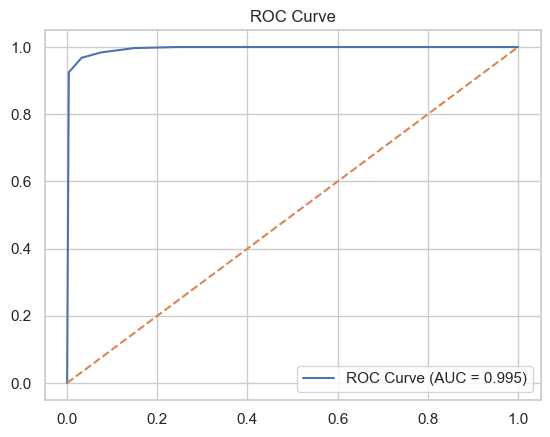

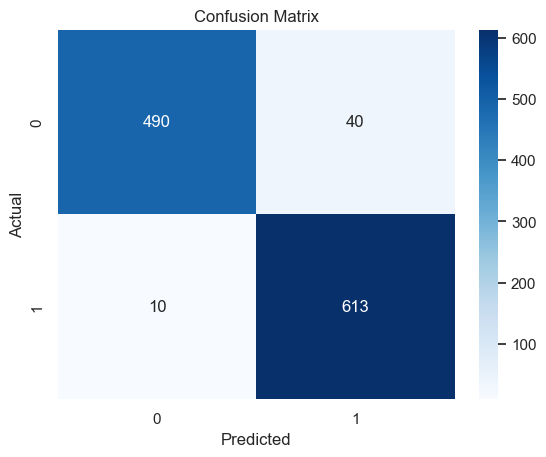

In [43]:
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    evaluate_model(model, X_train, X_test, y_train, y_test,name)


>>> Feature Importance for Random Forest


C:\Users\User\AppData\Local\Temp\ipykernel_17236\3659774274.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


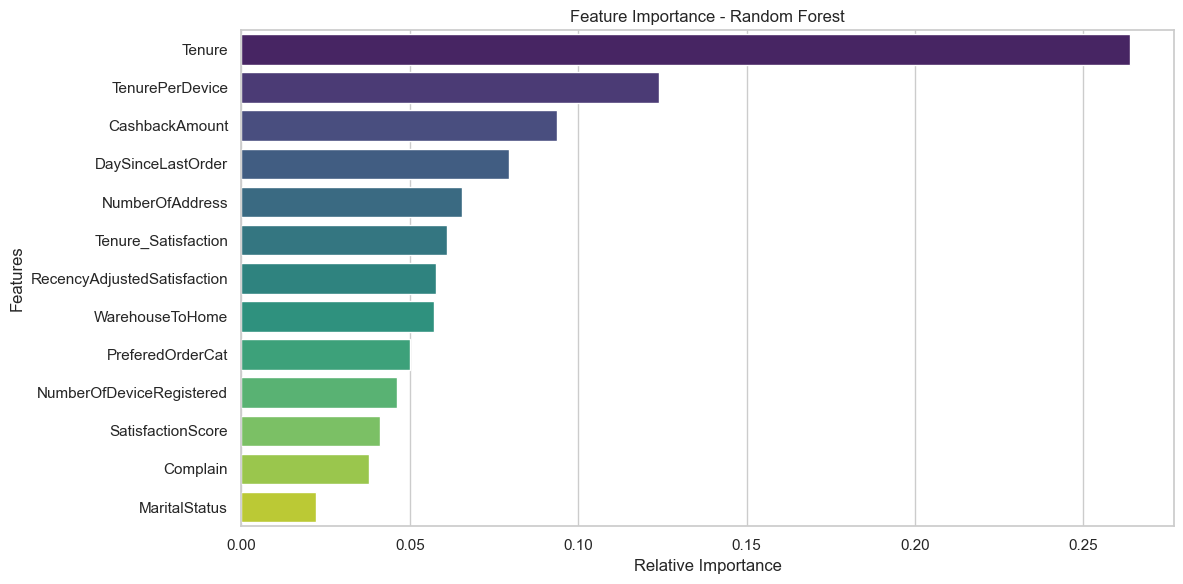


>>> Feature Importance for XGBoost


C:\Users\User\AppData\Local\Temp\ipykernel_17236\3659774274.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


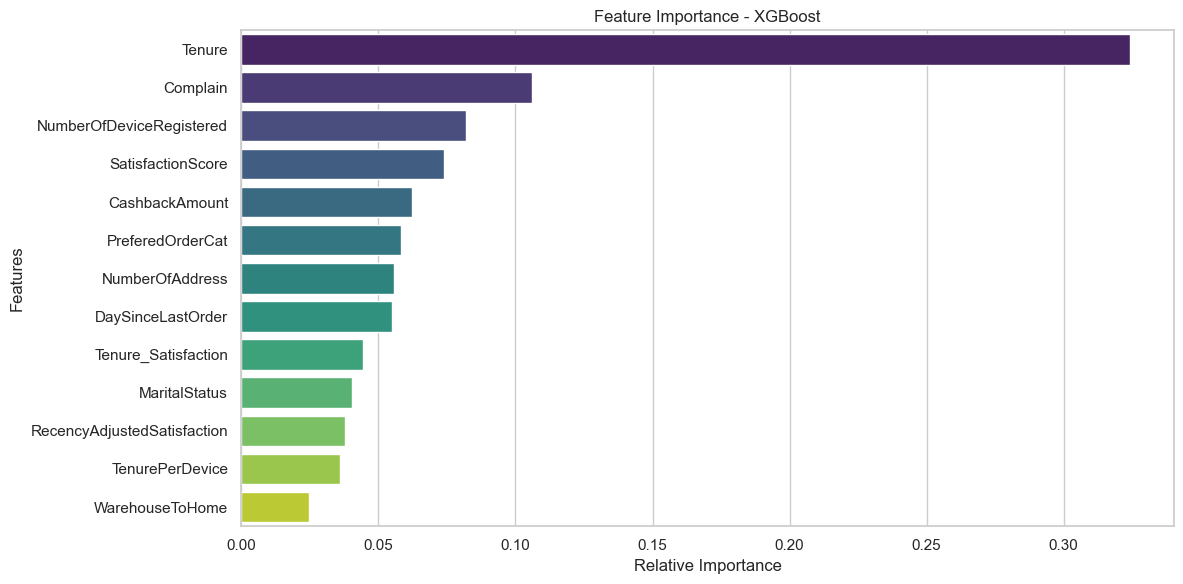


>>> Feature Importance for Logistic Regression


C:\Users\User\AppData\Local\Temp\ipykernel_17236\3659774274.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef[indices], y=np.array(feature_names)[indices], palette='coolwarm')


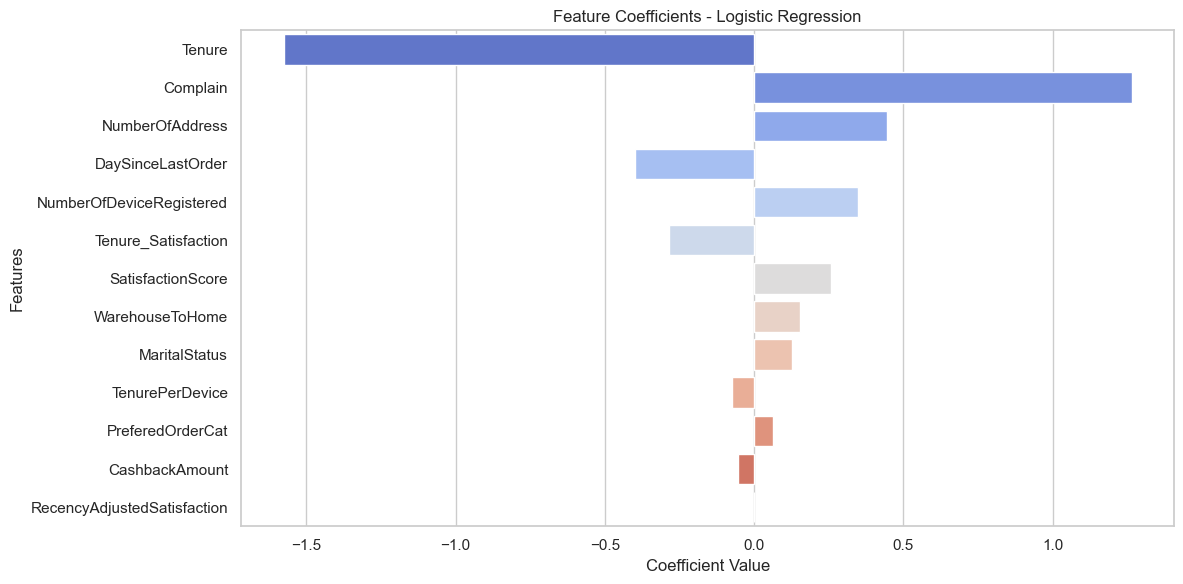


>>> Feature Importance for Gradient Boosting


C:\Users\User\AppData\Local\Temp\ipykernel_17236\3659774274.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


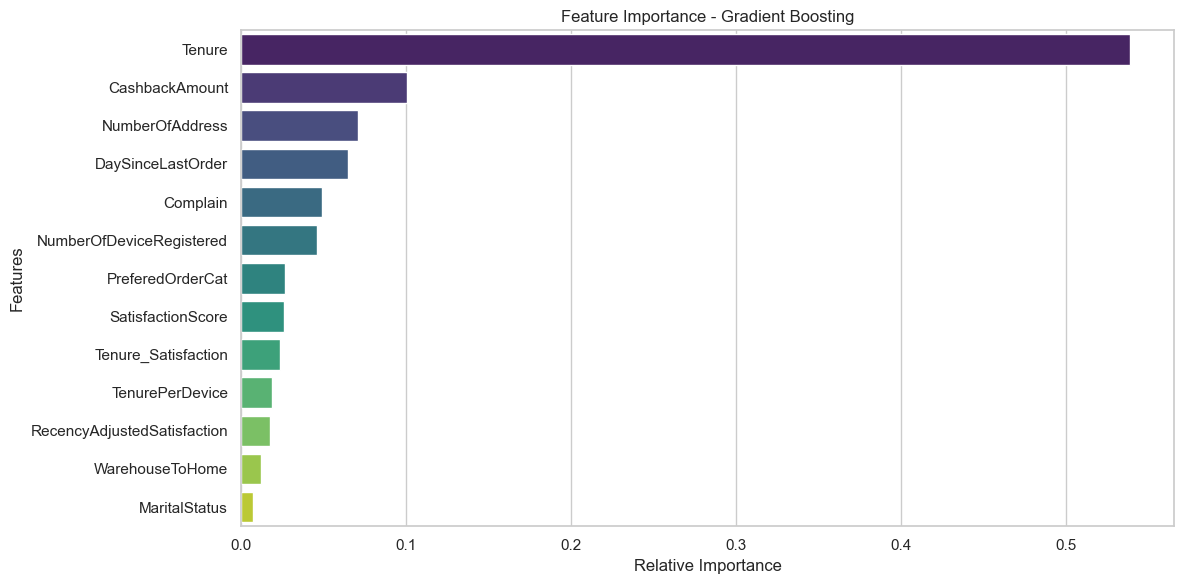


>>> Feature Importance for SVM
SVM does not support feature importance.

>>> Feature Importance for LightGBM


C:\Users\User\AppData\Local\Temp\ipykernel_17236\3659774274.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


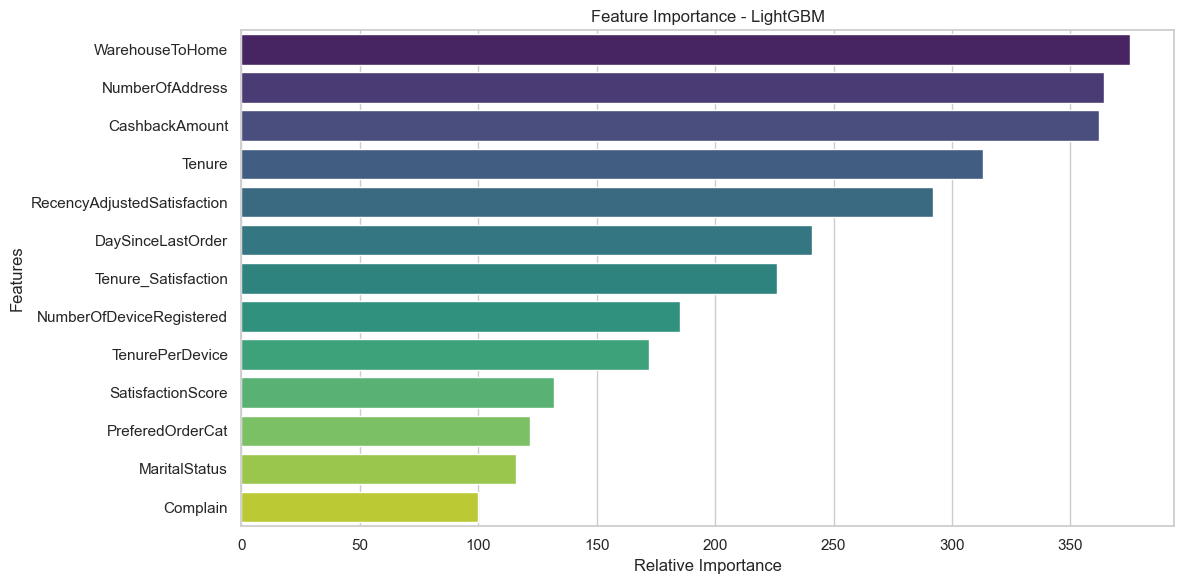


>>> Feature Importance for KNN
KNN does not support feature importance.


In [44]:
#Feature Importance Visualization
def plot_feature_importance(model, model_name, feature_names):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 6))
        plt.title(f'Feature Importance - {model_name}')
        sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')
        plt.xlabel('Relative Importance')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()
    elif hasattr(model, "coef_"):
        coef = model.coef_[0]
        indices = np.argsort(np.abs(coef))[::-1]
        
        plt.figure(figsize=(12, 6))
        plt.title(f'Feature Coefficients - {model_name}')
        sns.barplot(x=coef[indices], y=np.array(feature_names)[indices], palette='coolwarm')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not support feature importance.")
# Step 12: Display Feature Importance for All Applicable Models
for name, model in models.items():
    print(f"\n>>> Feature Importance for {name}")
    plot_feature_importance(model, name, X_selected_columns)

### Comparison of Model Metrics

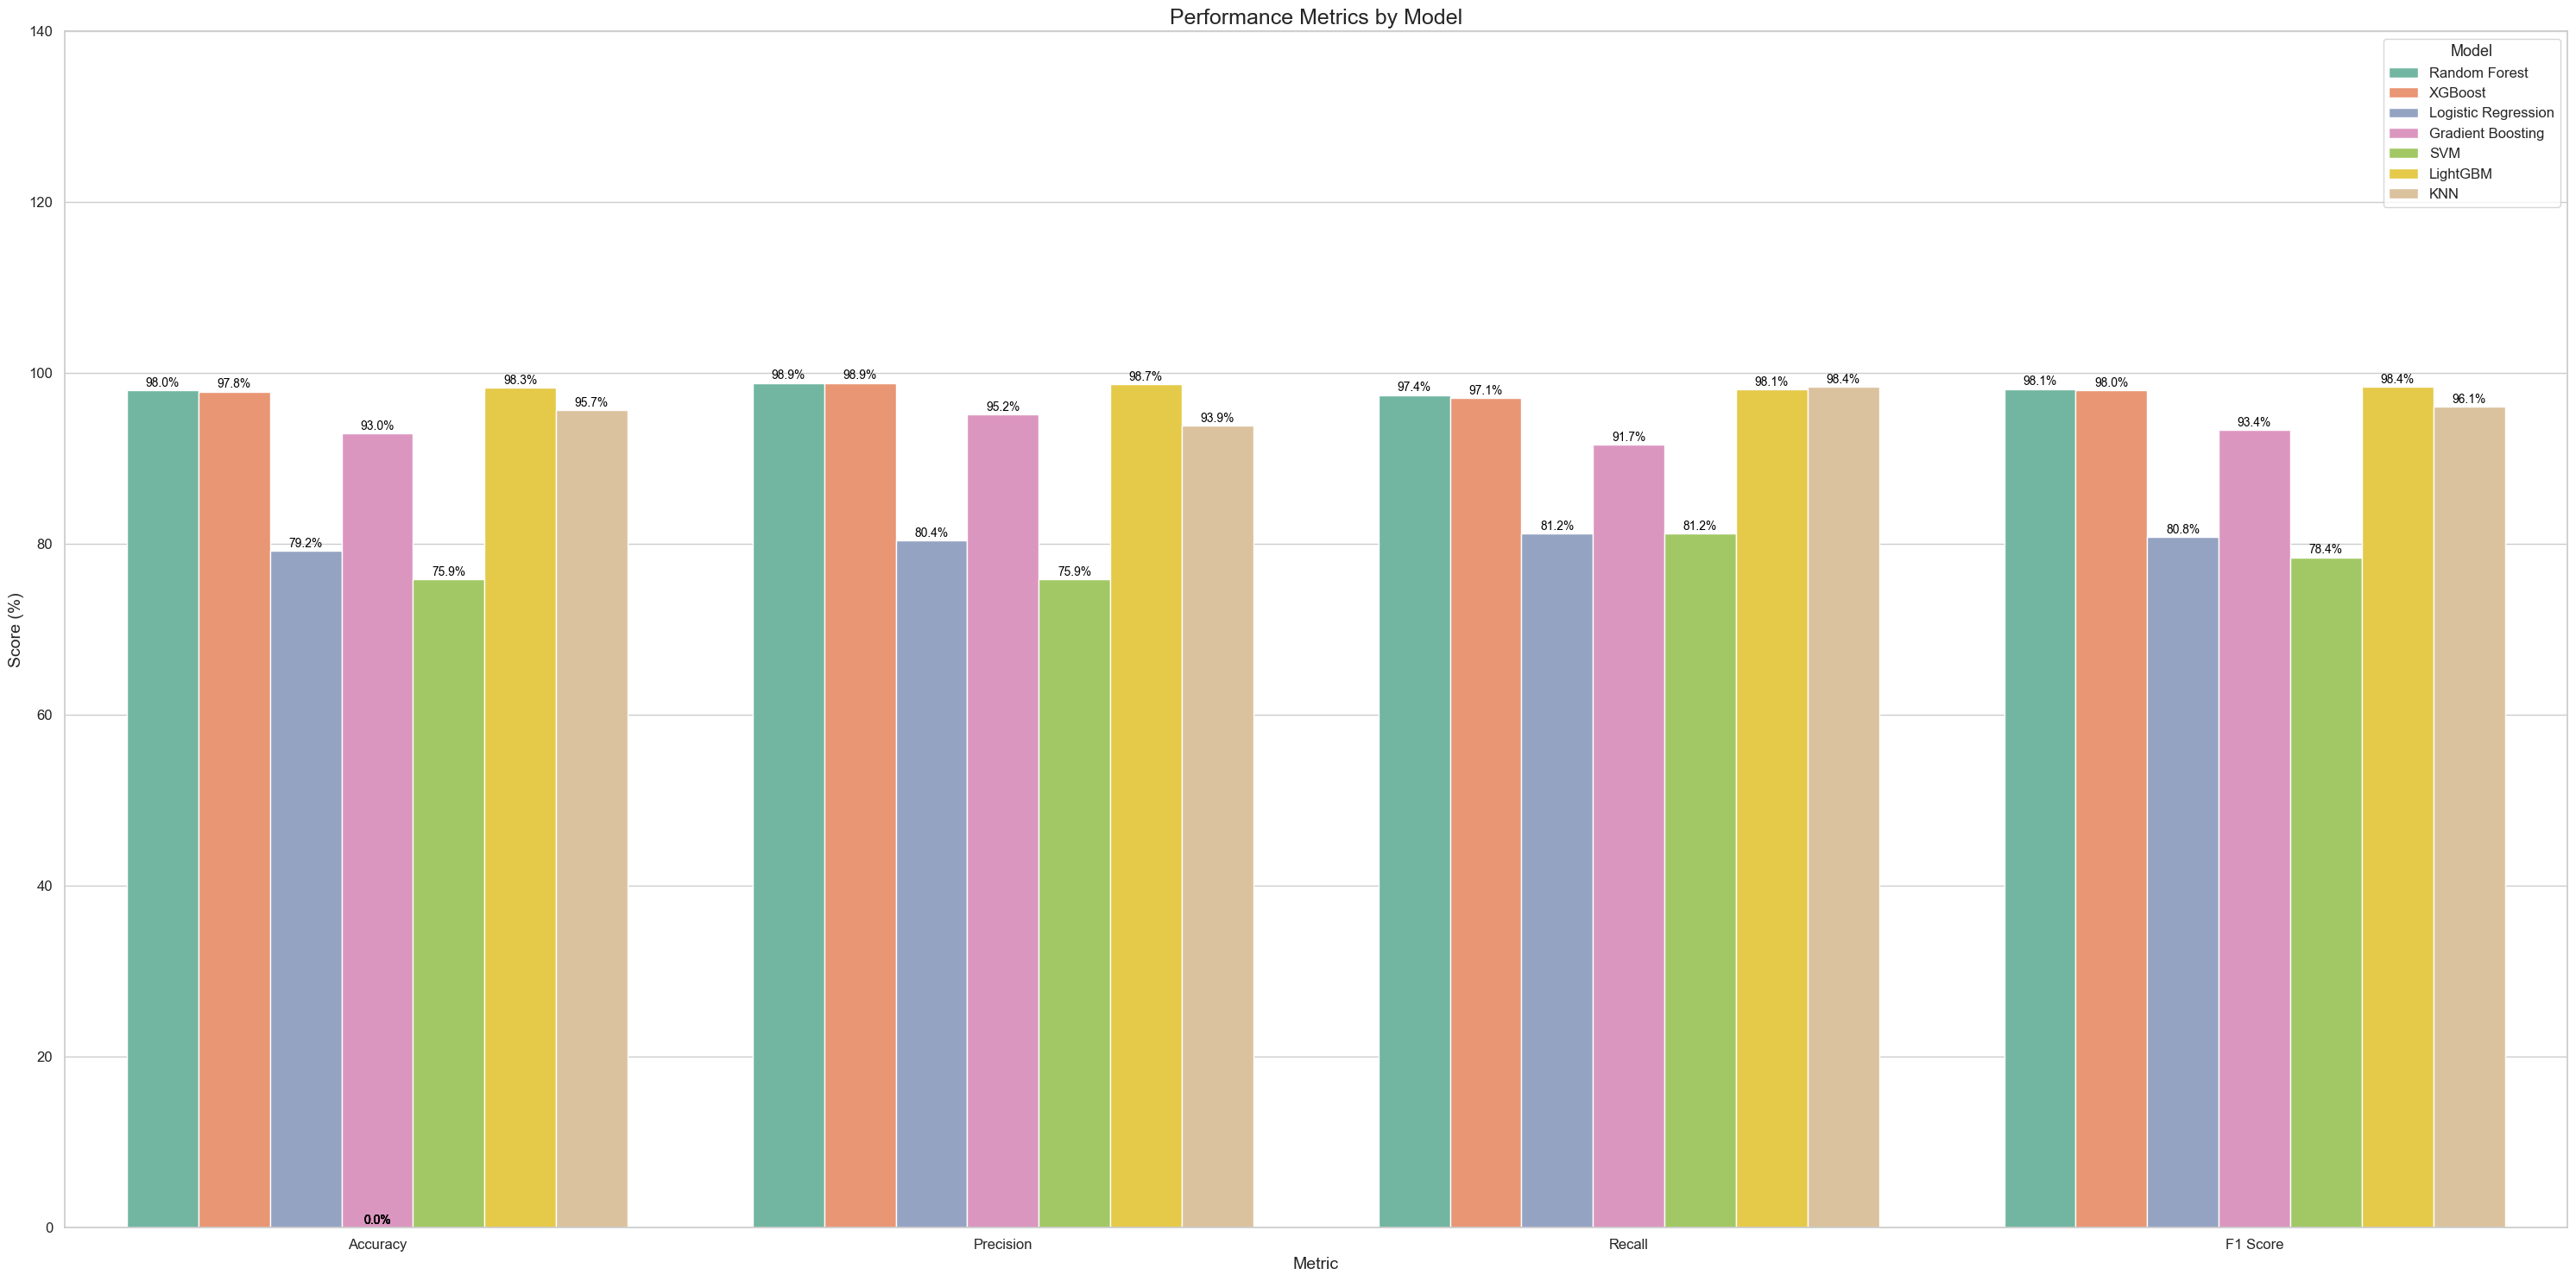

In [45]:

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

# Melt the DataFrame to long format
melted_df = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot using Seaborn
plt.figure(figsize=(30, 15))
sns.set(style="whitegrid")

sns.barplot(
    data=melted_df,
    x='Metric', y='Score', hue='Model',
    palette='Set2',
    width=.8
    
)

# Customize the plot
plt.title('Performance Metrics by Model', fontsize=18)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score (%)', fontsize=14)
plt.ylim(0, 140)  # Optional: Limit y-axis
plt.legend(title='Model', fontsize=12, title_fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show percentages on bars
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height:.1f}%', 
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center', fontsize=10, color='black',
                       xytext=(0, 6), textcoords='offset points')

plt.tight_layout()
plt.show()